# Plots for mutation growth rate paper

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update                       # Downloads and preprocesses data.
python mutrans.py --vary-holdout  # Fits and crossvalidates model.
```
Note that `make update` takes a couple hours the first time it is run (mostly in sequence alignment), and `mutrans.py` takes about 15 minutes on a GPU (will take much longer if no GPU is available).

In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [2]:
%%time
def load_data():
    filename = "results/mutrans.data.single.pt"
    if os.path.exists(filename):
        dataset = torch.load(filename)
    else:
        dataset = mutrans.load_gisaid_data()
        torch.save(dataset, filename)
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset
dataset = load_data()
locals().update(dataset)
for k, v in sorted(dataset.items()):
    if isinstance(v, torch.Tensor):
        print(f"{k} \t{type(v).__name__} of shape {tuple(v.shape)}")
    else:
        print(f"{k} \t{type(v).__name__} of size {len(v)}")

     4327 Loaded 531 x 3621 daily case data, totaling 217872032.0
     4328 Joining GISAID and JHU region codes
     4697 Matching 1070 GISAID regions to 3621 JHU fuzzy regions


daily_cases 	Tensor of shape (531, 1070)
features 	Tensor of shape (1281, 2337)
lineage_id 	dict of size 1281
lineage_id_inv 	list of size 1281
local_time 	Tensor of shape (42, 1070)
location_id 	OrderedDict of size 1070
mutations 	list of size 2337
weekly_cases 	Tensor of shape (42, 1070)
weekly_strains 	Tensor of shape (42, 1070, 1281)
CPU times: user 958 ms, sys: 308 ms, total: 1.27 s
Wall time: 1.18 s


In [3]:
print("{} x {} x {} = {}".format(*weekly_strains.shape, weekly_strains.shape.numel()))
print(int(weekly_strains.sum()))

42 x 1070 x 1281 = 57568140
2160748


In [4]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 2161248 samples


Sanity checking case count time series:

In [5]:
if False:
    plt.figure(figsize=(8, 3))
    plt.plot(weekly_cases, lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("confirmed cases");

    plt.figure(figsize=(8, 3))
    plt.plot(weekly_strains.sum(-1), lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("sequenced samples");

In [6]:
locations = set(location_id)
N_usa = sum(1 for k in locations if "/ USA /" in k)
N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
N_other = len(locations) - N_usa - N_uk
print(N_usa, N_uk, N_other)

52 4 1014


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [7]:
fits = torch.load("results/mutrans.pt", map_location="cpu")

In [8]:
for key in fits:
    print(key)

('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, ())
('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('include', (('location', '^Europe'),)),))
('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('exclude', (('location', '^Europe'),)),))


In [9]:
best_fit = list(fits.values())[0]
pretty_print(best_fit, max_items=40)

: dict of length 9
['median']: dict of length 12
['median']['coef_scale']: Tensor of shape ()
['median']['rate_scale']: Tensor of shape ()
['median']['init_loc_scale']: Tensor of shape ()
['median']['init_scale']: Tensor of shape ()
['median']['coef_decentered']: Tensor of shape (2337,)
['median']['coef']: Tensor of shape (2337,)
['median']['rate_loc']: Tensor of shape (1281,)
['median']['init_loc_decentered']: Tensor of shape (1281,)
['median']['init_loc']: Tensor of shape (1281,)
['median']['rate']: Tensor of shape (1070, 1281)
['median']['init']: Tensor of shape (1070, 1281)
['median']['probs']: Tensor of shape (48, 1070, 1281)
['mean']: dict of length 12
['mean']['init_loc_scale']: Tensor of shape ()
['mean']['coef_decentered']: Tensor of shape (2337,)
['mean']['coef']: Tensor of shape (2337,)
['mean']['probs']: Tensor of shape (48, 1070, 1281)
['mean']['rate']: Tensor of shape (1070, 1281)
['mean']['init_loc_decentered']: Tensor of shape (1281,)
['mean']['rate_scale']: Tensor of s

Scale `coef` by 1/100 in all results.

In [10]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix=""):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}")
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits)

.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, ()).median.coef
.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, ()).mean.coef
.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, ()).std.coef
.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('include', (('location', '^Europe'),)),)).median.coef
.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('include', (('location', '^Europe'),)),)).mean.coef
.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('include', (('location', '^Europe'),)),)).std.coef
.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('exclude', (('location', '^Europe'),)),)).median.coef
.('reparam-biased', 'coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 6, (('exclude', (('location', '^Europe'),)),)).mean.coef
.('reparam-biased', 'coef_scale=0.5', 'custo

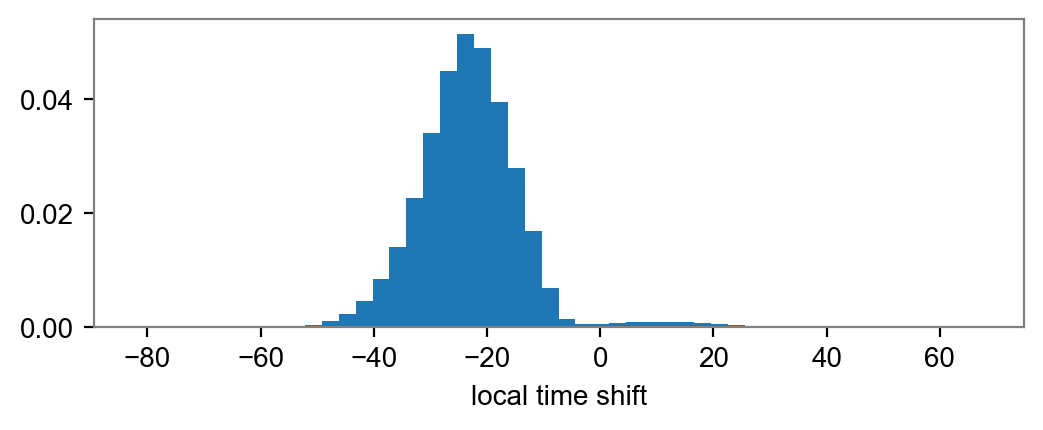

In [11]:
plt.figure(figsize=(6,2))
plt.hist(best_fit["params"]["local_time"].reshape(-1).numpy(), bins=50, density=True)
plt.xlabel("local time shift");

In [12]:
if False:
    plt.plot(
        best_fit["mean"]["init_loc"] + 0 * best_fit["median"]["init"],
        best_fit["median"]["init"],
        "k.",
    )


## Assess model fitness

In [ ]:
def plot_fits():
    num_nonzero = int(torch.count_nonzero(weekly_strains))
    for key, fit in fits.items():
        median = fit.get("median", fit.get("mean", {}))
        plt.figure(figsize=(8, 7))
        time = np.arange(1, 1 + len(fit["losses"]))
        plt.plot(fit["losses"], "k--", label="loss")
        locs = []
        grads = []
        for name, series in fit["series"].items():
            rankby = -torch.tensor(series).log1p().mean().item()
            if name.startswith("Guide."):
                name = name[len("Guide."):].replace("$$$", ".")
                grads.append((name, series, rankby))
            elif name.endswith("_centered") or name == "local_time":
                grads.append((name, series, rankby))
            elif name != "loss":
                locs.append((name, series, rankby))
        locs.sort(key=lambda x: x[-1])
        grads.sort(key=lambda x: x[-1])
        for name, series, _ in locs:
            plt.plot(time, series, label=name)
        for name, series, _ in locs:
            plt.plot(time, series, color="white", lw=3, alpha=0.3, zorder=-1)
        for name, series, _ in grads:
            plt.plot(time, series, lw=1, alpha=0.3, label=name, zorder=-2)
        plt.yscale("log")
        plt.xscale("log")
        plt.xlim(1, len(fit["losses"]))
        plt.legend(loc="upper left", fontsize=8)
        plt.xlabel("SVI step (duration = {:0.1f} minutes)".format(fit["walltime"]/60))
        loss = np.median(fit["losses"][-201:]) / num_nonzero
        scalars = " ".join([f"L={loss:0.6g}"] + [
            "{}={:0.3g}".format(
                "".join(p[0] for p in k.split("_")).upper(), v
            )
            for k, v in median.items()
            if v.numel() == 1
        ])
        plt.title("{} ({})\n{}".format(key[0], scalars, key[-1]))
plot_fits()

## Interpreting results

In [ ]:
def plusminus(mean, std):
    p95 = 1.96 * std
    return torch.stack([mean - p95, mean, mean + p95])

def plot_forecast(fit, queries=None, num_strains=10, filenames=[]):
    if queries is None:
        queries = list(location_id)
    elif isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1.5 + 2 * len(queries)), sharex=True)
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    dates = matplotlib.dates.date2num(mutrans.date_range(len(fit["mean"]["probs"])))
    forecast_steps = len(fit["mean"]["probs"]) - len(weekly_cases)
    assert forecast_steps >= 0
    probs = plusminus(fit["mean"]["probs"], fit["std"]["probs"])  # [3, T, P, S]
    padding = 1 + weekly_cases[-1:].expand(forecast_steps, -1)
    weekly_cases_ = torch.cat([weekly_cases, padding], 0)
    predicted = probs * weekly_cases_[..., None]
    ids = torch.tensor([i for name, i in location_id.items()
                        if any(q in name for q in queries)])
    strain_ids = weekly_strains[:, ids].sum([0, 1]).sort(-1, descending=True).indices
    strain_ids = strain_ids[:num_strains]
    colors = [f"C{i}" for i in range(10)] + ["black"] * 90
    assert len(colors) >= num_strains
    light = "#bbbbbb"
    for row, (query, ax) in enumerate(zip(queries, axes)):
        ids = torch.tensor([i for name, i in location_id.items() if query in name])
        print(f"{query} matched {len(ids)} regions")
        counts = weekly_cases[:, ids].sum(1)
        counts /= counts.max()
        ax.plot(dates[:len(counts)], counts, "k-", color=light, lw=0.8, zorder=-20)
        counts = weekly_strains[:, ids].sum([1, 2])
        counts /= counts.max()
        ax.plot(dates[:len(counts)], counts, "k--", color=light, lw=1, zorder=-20)
        pred = predicted.index_select(-2, ids).sum(-2)
        pred /= pred[1].sum(-1, True).clamp_(min=1e-8)
        obs = weekly_strains[:, ids].sum(1)
        obs /= obs.sum(-1, True).clamp_(min=1e-9)
        for s, color in zip(strain_ids, colors):
            lb, mean, ub = pred[..., s]
            ax.fill_between(dates, lb, ub, color=color, alpha=0.2, zorder=-10)
            ax.plot(dates, mean, color=color, lw=1, zorder=-9)
            strain = lineage_id_inv[s]
            ax.plot(dates[:len(obs)], obs[:, s], color=color, lw=0, marker='o', markersize=3,
                    label=strain if row == 0 else None)
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(query.replace(" / ", "\n"))
        ax.set_xlim(dates.min(), dates.max())
        if row == 0:
            ax.legend(loc="upper left", fontsize=8)
        elif row == 1:
            ax.plot([], "k--", color=light, lw=1, label="relative #samples")
            ax.plot([], "k-", color=light, lw=0.8, label="relative #cases")
            ax.plot([], lw=0, marker='o', markersize=3, color='gray',
                    label="observed portion")
            ax.fill_between([], [], [], color='gray', label="predicted portion")
            ax.legend(loc="upper left", fontsize=8)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0)
    for filename in filenames:
        plt.savefig(filename)

plot_forecast(best_fit,
              queries=["England", "USA / California", "Brazil"],
              num_strains=10,
              filenames=["paper/forecast.png"])

In [ ]:
def plot_prevalence(fit, filenames=()):
    rate = fit["median"]["rate"]
    if rate.dim() == 2:
        rate = rate.mean(0)
    rate = rate - rate[dataset["lineage_id"]["A"]]
    R = rate.exp()
    probs = fit["mean"]["probs"].mean(0)
    cases = torch.einsum("ps,p->s", probs, weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(10, 6))
    plt.scatter(R, cases, lw=0, alpha=0)
    for name, i in lineage_id.items():
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("symlog")
    plt.xscale("log")
    #plt.ylim(1, None)
    plt.xlim(0.9, None)
    lb10 = math.floor(10 * R.min().item())
    ub10 = math.ceil(10 * R.max().item())
    xticks = [x10 / 10 for x10 in range(lb10, ub10 + 1)]
    plt.xticks(xticks, list(map(str, xticks)))
    plt.xlabel("relative reproduction number $R_{strain} / R_A$")
    plt.title(f"Growth rate of {len(lineage_id)} PANGO lineages")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)

plot_prevalence(best_fit, ["paper/strain_prevalence.png"])

In [ ]:
def plot_volcano(mean, std, filenames=(), linthresh=2, top_k=60, plot_neg=False):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased growth rate of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("effect size (R / R_A = exp(μ))")
    xticks = [0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
    plt.xticks(list(map(math.log, xticks)), list(map(str, xticks)))
    plt.ylabel("statistical significance (|μ|/σ)")
    if plot_neg:
        lpad = 0.33 if any("," in mutations[i] for i in idx_neg[:N].tolist()) else 0.18
    else:
        lpad = 0
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    comment_pos = 0.8 if plot_neg else 0.3
    plt.text((1 - comment_pos) * x0 + comment_pos * x1, p95 * 0.95,
             "95% probabililty\nof correct sign(μ)",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    if plot_neg:
        for i in range(min(N, len(xs_neg))):
            x = x0
            _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
            plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='gray', lw=0.2)
            name = mutations[int(idx_neg[i])]
            plt.text(x, y, name + " ", color=colors.get(name.split(":")[0], "gray"),
                     fontsize=8, verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(best_fit["mean"]["coef"], best_fit["std"]["coef"], linthresh=2,
             filenames=["paper/volcano.png"])

In [ ]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, top_k=60, filenames=()):
    assert len(mean) == len(mutations)
    Y = mean
    y1 = Y.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    radius = 2 + 30 * (Y / Y.max())
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased growth rate of {len(mutations)} mutations")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), Y[mask].numpy(),
                    radius[mask].numpy(), color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": []}  # Many hits, plot with lines
    for i in Y.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(Y[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items() if v}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
        y_label = 0.2 * y + 0.8 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in set(special) - {"S"}:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1, color="gray")
        plt.axvline(end, lw=0.1, color="gray")
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("Δ log R")
    for f in filenames:
        plt.savefig(f)

plot_manhattan(best_fit["mean"]["coef"], top_k=55, filenames=["paper/manhattan.png"])

In [ ]:
def plot_manhattan_gene(gene, mean, top_k=200, filenames=()):
    assert len(mean) == len(mutations)
    Y = mean
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (gene_ids == gene_id[gene]) & (mean > 0)
    y1 = Y[mask].max().item()
    radius = 2 + 30 * (Y / Y[mask].max())

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased growth rate of mutations within {gene} gene")
    plt.scatter(position[mask].numpy(), Y[mask].numpy(),
                radius[mask].numpy(), color="darkblue", alpha=0.5, lw=0)
    special = []  # Many hits, plot with lines
    start, end = GENE_TO_POSITION[gene]
    z0, z1 = {
        # "ORF1a": (3500, 3750),
        "N": (180, 240),
        "S": (120, 180),
    }.get(gene, (0, 0))
    for i in Y.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(Y[i])
        g, name = mutations[i].split(":")
        pos = int(re.search("[0-9]+", name).group())
        if g != gene:
            continue
        if z0 < pos < z1:
            special.append((y, x, name))
        else:
            plt.text(x, y * 1.01 + + y1 / 60, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="center")
    special.sort(reverse=True)
    if special:
        lb = min(y for (y, _, _) in special)
        ub = max(y for (y, _, _) in special)
        lb, ub = lb * 0.5, ub * 0.1 + y1 * 0.9
        for i, (y, x, name) in enumerate(special):
            y_label = 0.1 * y + 0.9 * (ub + (lb - ub) * (i / (len(special) - 0.99)))
            x_label = start + 3 * z1
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    xticks = [start]
    dx = 150
    while end - start > dx * 12:
        dx *= 2
    while xticks[-1] + dx < end:
        xticks.append(xticks[-1] + dx)
    labels = [str((x - start) // 3) for x in xticks]
    plt.xticks(xticks, labels)
    plt.xlabel(f"amino acid position within {gene} gene")
    plt.xlim(start, end)
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("Δ log R")
    for f in filenames:
        plt.savefig(f)

plot_manhattan_gene("ORF1a", best_fit["mean"]["coef"], 100, filenames=["paper/manhattan_ORF1a.png"])
plot_manhattan_gene("S", best_fit["mean"]["coef"], 300, filenames=["paper/manhattan_S.png"])
plot_manhattan_gene("N", best_fit["mean"]["coef"], 350, filenames=["paper/manhattan_N.png"])

## Extracting a table of top mutations and their stories

In [ ]:
def rank_mutations(fit, names):
    mean = fit["mean"]["coef"]
    std = fit["std"]["coef"]
    sigma = mean / std.clamp(min=1e-8)
    ranks = sigma.sort(0, descending=True).indices.tolist()
    assert len(ranks) == len(mutations)
    ranked = [mutations[k] for k in ranks]
    ranks = {m: i for i, m in enumerate(ranked)}
    print("Mut'n\tRank\tEstimate")
    for name in names:
        i = mutations.index(name)
        print("{}\t{}\t{:0.3g} ± {:0.2g}".format(name, ranks[name], mean[i], std[i]))

rank_mutations(best_fit, ["S:D614G", "S:N501Y", "S:E484K", "S:L452R"])

In [ ]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [ ]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [ ]:
def write_mutation_table(fit, filename):
    assert filename.endswith(".tsv")
    mean = fit["mean"]["coef"]
    std = fit["std"]["coef"]
    sigma = mean / std.clamp(min=1e-8)
    if "samples" in fit:
        lb, ub = stats.confidence_interval(0.95, fit["samples"]["coef"])
    else:
        lb, ub = dist.Normal(mean, std).icdf(torch.tensor([0.025, 0.975])[:, None])
    R_RA = mean.exp()  # mean is in units of generation time.
    lineage_counts = weekly_strains.sum((0, 1))
    schema = [
        ("rank", "{:d}"),
        ("mutation", "{:s}"),
        ("mean/stddev", "{:0.6g}"),
        ("Δ log R", "{:0.6g}"),
        ("Δ log R 95% ci lower", "{:0.6g}"),
        ("Δ log R 95% ci upper", "{:0.6g}"),
        ("R / R_A", "{:0.6g}"),
        ("R / R_A 95% ci lower", "{:0.6g}"),
        ("R / R_A 95% ci lower", "{:0.6g}"),
        ("emerged in lineages", "{:s}"),  
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(sigma.sort(0, descending=True).indices.tolist()):
            emerged = find_emergences(i)
            f.write(row.format(
                rank + 1, mutations[i],
                sigma[i], mean[i], lb[i], ub[i], R_RA[i], lb[i].exp(), ub[i].exp(),
                ", ".join(emerged)
            ))

write_mutation_table(best_fit, "paper/mutations.tsv")
pd.read_csv("paper/mutations.tsv", sep="\t")

In [ ]:
print(columns.keys())

In [ ]:
def estimate_lineage_bdays(exclude_first=10):
    lineage_days = defaultdict(list)
    for lineage, day in zip(columns["lineage"], columns["day"]):
        lineage = pangolin.decompress(lineage)
        lineage_days[lineage].append(day)
    lineage_bday = {}
    for lineage, days in list(lineage_days.items()):
        days.sort()
        lineage_bday[lineage] = days[min(exclude_first, len(days) // 10)]
    start_date = datetime.datetime.strptime(mutrans.START_DATE, "%Y-%m-%d")
    return {
        lineage: (start_date + datetime.timedelta(days=day)).strftime("%Y-%m-%d")
        for lineage, day in lineage_bday.items()
    }

lineage_bday = estimate_lineage_bdays()

In [ ]:
def write_strain_table(fit, filename):
    assert filename.endswith(".tsv")
    rate_mean = fit["mean"]["rate"].mean(0)
    rate_std = (fit["std"]["rate"].mean(0) ** 2 + fit["mean"]["rate"].std(0) ** 2).sqrt()
    sigma = rate_mean / rate_std.clamp(min=1e-8)
    R_mean = rate_mean.exp()
    lb, ub = dist.Normal(rate_mean, rate_std).icdf(torch.tensor([0.025, 0.975])[..., None])
    RA = R_mean[lineage_id["A"]].item()
    R_RA = R_mean / RA
    lb = lb / RA
    ub = ub / RA
    probs = fit["median"]["probs"][:len(weekly_cases)]
    cases = torch.einsum("tps,tp->ts", probs, weekly_cases)
    cases_per_day = cases[-2] / mutrans.TIMESTEP
    cases_total = cases.sum(0)
    schema = [
        ("rank", "{:d}"),
        ("strain", "{:s}"),
        ("mean/stddev", "{:.6g}"),
        ("R / R_A", "{:.6g}"),
        ("R / R_A 95% ci lower", "{:.6g}"),
        ("R / R_A 95% ci upper", "{:.6g}"),
        ("confirmed cases / day", "{:.6g}"),
        ("confirmed cases total", "{:.6g}"),
        ("birthday", "{:s}"),
        ("mutations", "{:s}"),
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(R_RA.sort(0, descending=True).indices.tolist()):
            lineage = lineage_id_inv[i]
            lineage_mutations = ",".join(
                mutations[m] for m in features[i].nonzero(as_tuple=True)[0].tolist()
            )
            f.write(row.format(
                rank + 1, lineage,
                sigma[i], R_RA[i], lb[i], ub[i], cases_per_day[i], cases_total[i],
                lineage_bday[pangolin.decompress(lineage)],
                lineage_mutations,
            ))

write_strain_table(best_fit, "paper/strains.tsv")
pd.read_csv("paper/strains.tsv", sep="\t")

## Comparison with deep mutational scans

We first compare with [(Starr et al. 2020)](https://www.sciencedirect.com/science/article/pii/S0092867420310035) who study S mutations affecting folding and ACE2 binding.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S0092867420310035-mmc2.csv")
df

In [ ]:
folding = {f"S:{m}": float(e) for m, e in zip(df["mutation"], df["expr_avg"])}
binding = {f"S:{m}": float(b) for m, b in zip(df["mutation"], df["bind_avg"])}
print(sum(1 for m in mutations if m in folding))

We next compare with [(Greaney et al. 2021)](https://www.sciencedirect.com/science/article/pii/S1931312820306247) who study antibody escape.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S1931312820306247-mmc2.csv")
df

In [ ]:
escape = {
    f"S:{w}{s}{m}": float(e)
    for w, s, m, e in zip(df["wildtype"], df["site"], df["mutation"], df["mut_escape"])
}
print(sum(1 for m in mutations if m in escape))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ms = [m for m in mutations if m in escape]
y = best_fit["mean"]["coef"][[i for i, m in enumerate(mutations) if m in escape]].numpy()
axes[0].set_ylabel("Δ log R")
for name, ax in zip(["folding", "binding", "escape"], axes):
    scan = locals()[name]
    x = torch.tensor([scan[m] for m in ms]).numpy()
    # ax.scatter(x, y, alpha=0.5, lw=0)
    for xm, ym, m in zip(x, y, ms):
        ax.text(xm, ym, m[2:], fontsize=6,
                verticalalignment="center", horizontalalignment="center")
    ax.set_xlim(1.08 * x.min() - 0.08 * x.max(), 1.08 * x.max() - 0.08 * x.min())
    ax.set_ylim(1.05 * y.min() - 0.05 * y.max(), 1.05 * y.max() - 0.05 * y.min())
    ax.set_xlabel(f"{name} (ρ = {pearson_correlation(x, y):0.2g})")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
axes[2].set_xscale("log")
axes[2].set_xlim(x.min() ** 1.08 / x.max() ** 0.08, x.max() ** 1.08 / x.min() ** 0.08)
axes[1].set_title(f"Comparison of {len(ms)} S gene mutations to deep scanning")
plt.subplots_adjust(wspace=0)

It's hard to say whether these correlations are meaningful, as they are dominated by a few outliers.

Let's fit a linear model regressing growth rate against theses deep scanning results.

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.optim import Adam

def fit_model(fit):
    trans_data = fit["mean"]["coef"][[i for i, m in enumerate(mutations) if m in escape]]
    folding_data = torch.tensor([folding[m] for m in ms])
    binding_data = torch.tensor([binding[m] for m in ms])
    escape_data = torch.tensor([escape[m] for m in ms])
    
    def model():
        coef = pyro.sample("coef", dist.Normal(0, 10).expand([5]).to_event(1))
        t, f, b, e, be = coef.unbind(-1)
        noise = pyro.sample("noise", dist.LogNormal(0, 2))
        with pyro.plate("data", len(trans_data)):
            pred = (
                t + f * folding_data + b * binding_data + e * escape_data
                + be * binding_data * escape_data
            )
            pyro.sample("trans", dist.Normal(pred, noise), obs=trans_data)

    pyro.clear_param_store()
    guide = AutoMultivariateNormal(model)
    elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
    svi = SVI(model, guide, Adam({"lr": 0.2}), elbo)
    for step in range(201):
        loss = svi.step()
        if step % 20 == 0:
            print(f"step {step} loss = {loss:0.4g}")
    loc, scale = guide._loc_scale()
    print("Model:")
    print("growth rate = t + f folding + b binding + e escape + be binding escape")
    print("Learned coefficients:")
    for k, l, s in zip("t f b e be".split(), loc.tolist(), scale.tolist()):
        print(f"{k} = {l:0.4g} +- {s:0.2f}")
        
fit_model(best_fit)

## Fit on subsets of data

In [ ]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "North America " in n]).most_common(2))
print(Counter([n for n in columns["location"] if "Europe " in n]).most_common(2))

In [ ]:
holdout_fits = {k[-1]: v for k, v in fits.items() if k[-1]}
for key in holdout_fits:
    print(key[-1])

In [ ]:
aliases = [
    "full data",
    "only Europe",
    "excluding Europe",
    # "only North America",
    # "excluding North America",
    # "only the USA",
    # "excluding the USA",
    # "excluding the UK",
    # "only the UK",
    # "only CDC data",
    # "only CDC NS3 data",
]
holdout_fits = dict(zip(aliases, [best_fit] + list(holdout_fits.values())))
assert len(holdout_fits) == 3

In [ ]:
def plot_mutation_agreements(holdouts, filenames=()):
    def get_mean(fit):
        return fit["mean"]["coef"]
    (name0, fit0), (name1, fit1), (name2, fit2) = holdouts.items()
    pairs = [
        [(name0, fit0), (name1, fit1)],
        [(name0, fit0), (name2, fit2)],
        [(name1, fit1), (name2, fit2)],
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in means)
    x1 = max(mean.max().item() for mean in means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig.suptitle("Δ log R for {} mutations estimated from subsets of data"
                 .format(len(list(holdouts.values())[0]["mutations"])))
    for ax, ((name1, fit1), (name2, fit2)) in zip(axes, pairs):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = []
        for fit in (fit1, fit2):
            m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
            idx = torch.tensor([m_to_i[m] for m in mutations])
            means.append(get_mean(fit)[idx])
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(pearson_correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_ylim(lb, ub)
        ax.set_xlabel(name2)
        ax.set_ylabel(name1)
    plt.subplots_adjust(wspace=0.12)
    for f in filenames:
        plt.savefig(f)

plot_mutation_agreements(holdout_fits, ["paper/mutation_agreement.png"])

In [ ]:
def plot_strain_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        rate = fit["median"]["rate"]
        if rate.dim() == 2:
            rate = rate.median(0).values
        return (rate - rate[lineage_id["A"]]).exp()
    (name0, fit0), (name1, fit1), (name2, fit2) = holdouts.items()
    pairs = [
        [(name0, fit0), (name1, fit1)],
        [(name0, fit0), (name2, fit2)],
        [(name1, fit1), (name2, fit2)],
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in means)
    x1 = max(mean.max().item() for mean in means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig.suptitle("$R_{{lineage}} / R_A$ for {} lineages esimated from subsets of data"
                 .format(len(lineage_id)))
    for ax, ((name1, fit1), (name2, fit2)) in zip(axes, pairs):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = [get_mean(fit) for fit in (fit1, fit2)]
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(pearson_correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_ylim(lb, ub)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
    plt.subplots_adjust(wspace=0.12)
    for f in filenames:
        plt.savefig(f)

plot_strain_agreements(best_fit, holdout_fits, ["paper/lineage_agreement.png"])

In [ ]:
def plot_mutation_subset_boxplot(fits, rankby="t", top_k=20, filenames=()):
    best_fit = list(fits.values())[1]
    if rankby == "s":
        rankby = best_fit["mean"]["coef"] / best_fit["std"]["coef"]
        title = f"Top {top_k} most statistically significant mutations"
    elif rankby == "t":
        rankby = best_fit["mean"]["coef"]
        title = f"Top {top_k} mutations associated with increased growth rate"
    else: raise ValueError(rankby)
    top_indices = rankby.sort(0, descending=True).indices[:top_k]
    top_mutations = [mutations[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["coef"].T[top_indices].T
        else:
            mean = fit["mean"]["coef"][top_indices]
            std = fit["std"]["coef"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean(0)
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]
    
    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 9})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               # labels=[x.replace(":", ":\n") for x in top_mutations],
               labels=top_mutations, rotation=-90, fontsize=9)
    plt.ylabel("Δ log R")
    plt.title(title)
    for f in filenames:
        plt.savefig(f)

for name in ["Europe"]:
    name_ = name.lower().replace(" ", "_")
    plot_mutation_subset_boxplot({
        f"World w/o {name}": holdout_fits[f"excluding {name}"],
        "World": best_fit,
        f"{name} only": holdout_fits[f"only {name}"],
    }, filenames=[f"paper/mutation_{name_}_boxplot.png"])

In [ ]:
def plot_strain_subset_boxplot(fits, top_k=20, filenames=()):
    def get_rate(stats):
        rate = stats["rate"]
        if rate.dim() == 2:
            rate = rate.median(0).values
        return rate
    best_fit = list(fits.values())[1]
    top_indices = get_rate(best_fit["median"]).sort(0, descending=True).indices[:top_k]
    top_lineages = [lineage_id_inv[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        mean = get_rate(fit["median"])[top_indices]
        std = get_rate(fit["std"])[top_indices]
        samples = dist.Normal(mean, std).sample((1000,))
        samples = samples - get_rate(fit["median"])[lineage_id["A"]]
        samples = samples.exp()
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean()
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]

    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 10})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               labels=top_lineages, rotation=-90)
    plt.ylabel("$R / R_A$")
    plt.title(f"Top {top_k} lineages with highest growth rate")
    for f in filenames:
        plt.savefig(f)

for name in ["Europe"]:
    name_ = name.lower().replace(" ", "_")
    plot_strain_subset_boxplot({
        f"World w/o {name}": holdout_fits[f"excluding {name}"],
        "World": best_fit,
        f"{name} only": holdout_fits[f"only {name}"],
    }, filenames=[f"paper/strain_{name_}_boxplot.png"])